In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

# Dataset & Dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [4]:
train_set

Dataset ImageFolder
    Number of datapoints: 40000
    Root location: data/train/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [5]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 1, 28, 28])

In [6]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur & Config

In [7]:
from jcopdl.layers import linear_block

In [8]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout =dropout),
            linear_block(n1, n2, dropout =dropout),
            linear_block(n2, output_size, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(x)

In [9]:
config = set_config({
    "input_size": 784,
    "n1": 256,
    "n2": 64,
    "output_size": len(train_set.classes),
    "dropout": 0.2
})

# Training Preparation -> MCOC

In [10]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [11]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
                
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                    
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.7369 | Test_cost  = 0.4682 | Train_score = 0.7382 | Test_score = 0.8347 |




Epoch     2
Train_cost  = 0.4777 | Test_cost  = 0.4202 | Train_score = 0.8290 | Test_score = 0.8456 |




Epoch     3
Train_cost  = 0.4202 | Test_cost  = 0.3817 | Train_score = 0.8520 | Test_score = 0.8588 |




Epoch     4
Train_cost  = 0.3920 | Test_cost  = 0.3709 | Train_score = 0.8608 | Test_score = 0.8620 |




Epoch     5
Train_cost  = 0.3680 | Test_cost  = 0.3418 | Train_score = 0.8679 | Test_score = 0.8746 |




Epoch     6
Train_cost  = 0.3515 | Test_cost  = 0.3436 | Train_score = 0.8724 | Test_score = 0.8725 |
==> EarlyStop patience =  1 | Best test_score: 0.8746




Epoch     7
Train_cost  = 0.3369 | Test_cost  = 0.3316 | Train_score = 0.8782 | Test_score = 0.8784 |




Epoch     8
Train_cost  = 0.3287 | Test_cost  = 0.3283 | Train_score = 0.8805 | Test_score = 0.8788 |




Epoch     9
Train_cost  = 0.3152 | Test_cost  = 0.3191 | Train_score = 0.8855 | Test_score = 0.8829 |




Epoch    10
Train_cost  = 0.3041 | Test_cost  = 0.3153 | Train_score = 0.8884 | Test_score = 0.8823 |
==> EarlyStop patience =  1 | Best test_score: 0.8829




Epoch    11
Train_cost  = 0.3041 | Test_cost  = 0.3123 | Train_score = 0.8892 | Test_score = 0.8858 |




Epoch    12
Train_cost  = 0.2893 | Test_cost  = 0.3232 | Train_score = 0.8942 | Test_score = 0.8814 |
==> EarlyStop patience =  1 | Best test_score: 0.8858




Epoch    13
Train_cost  = 0.2848 | Test_cost  = 0.3261 | Train_score = 0.8939 | Test_score = 0.8813 |
==> EarlyStop patience =  2 | Best test_score: 0.8858




Epoch    14
Train_cost  = 0.2772 | Test_cost  = 0.3110 | Train_score = 0.8984 | Test_score = 0.8880 |




Epoch    15
Train_cost  = 0.2712 | Test_cost  = 0.3179 | Train_score = 0.8991 | Test_score = 0.8832 |
==> EarlyStop patience =  1 | Best test_score: 0.8880




Epoch    16
Train_cost  = 0.2656 | Test_cost  = 0.3214 | Train_score = 0.9023 | Test_score = 0.8825 |
==> EarlyStop patience =  2 | Best test_score: 0.8880




Epoch    17
Train_cost  = 0.2615 | Test_cost  = 0.3181 | Train_score = 0.9041 | Test_score = 0.8854 |
==> EarlyStop patience =  3 | Best test_score: 0.8880




Epoch    18
Train_cost  = 0.2557 | Test_cost  = 0.3027 | Train_score = 0.9054 | Test_score = 0.8927 |




Epoch    19
Train_cost  = 0.2510 | Test_cost  = 0.3099 | Train_score = 0.9060 | Test_score = 0.8879 |
==> EarlyStop patience =  1 | Best test_score: 0.8927




Epoch    20
Train_cost  = 0.2493 | Test_cost  = 0.3093 | Train_score = 0.9079 | Test_score = 0.8860 |


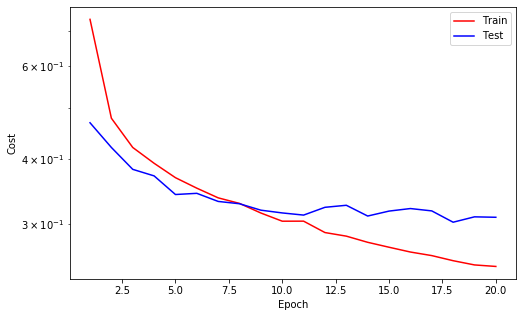

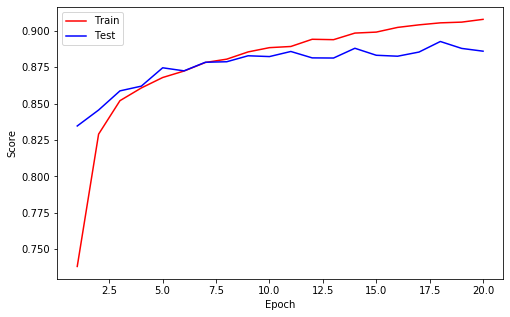

==> EarlyStop patience =  2 | Best test_score: 0.8927




Epoch    21
Train_cost  = 0.2402 | Test_cost  = 0.3144 | Train_score = 0.9112 | Test_score = 0.8899 |
==> EarlyStop patience =  3 | Best test_score: 0.8927




Epoch    22
Train_cost  = 0.2360 | Test_cost  = 0.3076 | Train_score = 0.9105 | Test_score = 0.8928 |




Epoch    23
Train_cost  = 0.2344 | Test_cost  = 0.3102 | Train_score = 0.9133 | Test_score = 0.8899 |
==> EarlyStop patience =  1 | Best test_score: 0.8928




Epoch    24
Train_cost  = 0.2294 | Test_cost  = 0.3237 | Train_score = 0.9146 | Test_score = 0.8870 |
==> EarlyStop patience =  2 | Best test_score: 0.8928




Epoch    25
Train_cost  = 0.2256 | Test_cost  = 0.3116 | Train_score = 0.9156 | Test_score = 0.8924 |
==> EarlyStop patience =  3 | Best test_score: 0.8928




Epoch    26
Train_cost  = 0.2249 | Test_cost  = 0.3201 | Train_score = 0.9149 | Test_score = 0.8910 |
==> EarlyStop patience =  4 | Best test_score: 0.8928




Epoch    27
Train_cost  = 0.2188 | Test_cost  = 0.3196 | Train_score = 0.9169 | Test_score = 0.8865 |
==> EarlyStop patience =  5 | Best test_score: 0.8928
==> Execute Early Stopping at epoch: 27 | Best test_score: 0.8928
==> Best model is saved at model


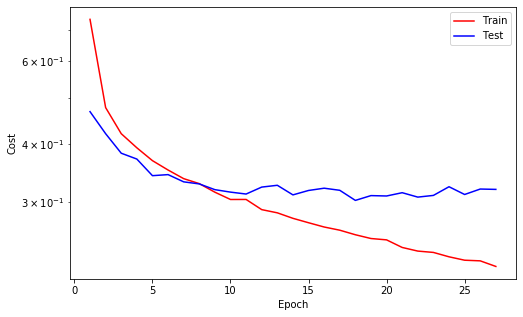

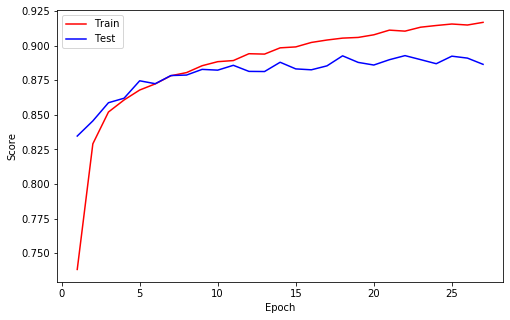

In [12]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    #Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break
    

# Load Best Model

In [13]:
weights = torch.load("model/weights_best.pth", map_location="cpu")
config = torch.load("model/configs.pth", map_location="cpu")

model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
model.load_state_dict(weights)
model = model.to(device)

In [16]:
model.state_dict()

OrderedDict([('fc.1.0.weight',
              tensor([[-0.0777, -0.1926, -0.2095,  ..., -0.0035, -0.1980, -0.1258],
                      [ 0.1318,  0.2405, -0.0095,  ...,  0.0491,  0.2793,  0.3436],
                      [-0.2146,  0.0180, -0.3960,  ...,  0.0329, -0.2143, -0.1743],
                      ...,
                      [ 0.0113, -0.1791, -0.1054,  ..., -0.1850, -0.2468, -0.2666],
                      [-0.0715, -0.0429, -0.2055,  ...,  0.0274, -0.0917, -0.1345],
                      [ 0.1835,  0.2756,  0.1275,  ..., -0.0407,  0.2841, -0.0527]],
                     device='cuda:0')),
             ('fc.1.0.bias',
              tensor([ 3.5441e-01, -2.5570e-01,  2.5517e-01,  2.5283e-01, -9.8352e-05,
                       1.8154e-01, -1.2611e-02,  4.5139e-02,  5.1539e-01,  6.8012e-02,
                      -1.2375e-02, -2.3264e-01,  1.3000e-01,  4.1648e-01,  2.1029e-01,
                       3.9814e-01, -1.9306e-02,  3.1806e-01,  1.0519e-01, -1.4826e-01,
                    

# Predict

In [17]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [19]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['Dress',
 'Shirt',
 'Coat',
 'Coat',
 'Dress',
 'Coat',
 'Sneaker',
 'Sneaker',
 'Coat',
 'Coat',
 'Bag',
 'Ankle boot',
 'Coat',
 'Trouser',
 'Pullover',
 'Sandal',
 'T-shirt or Top',
 'Bag',
 'Shirt',
 'Dress',
 'Pullover',
 'Sneaker',
 'Pullover',
 'T-shirt or Top',
 'Dress',
 'Coat',
 'Sandal',
 'Coat',
 'T-shirt or Top',
 'Sandal',
 'Pullover',
 'Ankle boot',
 'Trouser',
 'Trouser',
 'Dress',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'T-shirt or Top',
 'T-shirt or Top',
 'Dress',
 'Dress',
 'Sandal',
 'Pullover',
 'Coat',
 'Trouser',
 'Trouser',
 'Trouser',
 'Shirt',
 'Bag',
 'Shirt',
 'Trouser',
 'Coat',
 'T-shirt or Top',
 'Trouser',
 'T-shirt or Top',
 'Sandal',
 'Trouser',
 'Bag',
 'Sandal',
 'Ankle boot',
 'Dress',
 'Sneaker',
 'Sneaker',
 'T-shirt or Top',
 'T-shirt or Top',
 'Dress',
 'Dress',
 'Pullover',
 'Dress',
 'Shirt',
 'Bag',
 'Bag',
 'Trouser',
 'T-shirt or Top',
 'Dress',
 'T-shirt or Top',
 'Bag',
 'Coat',
 'Ankle boot',
 'Shirt',
 'Dress',
 'Dress',
 'Trous

# Visualisasi

In [20]:
import matplotlib.pyplot as plt

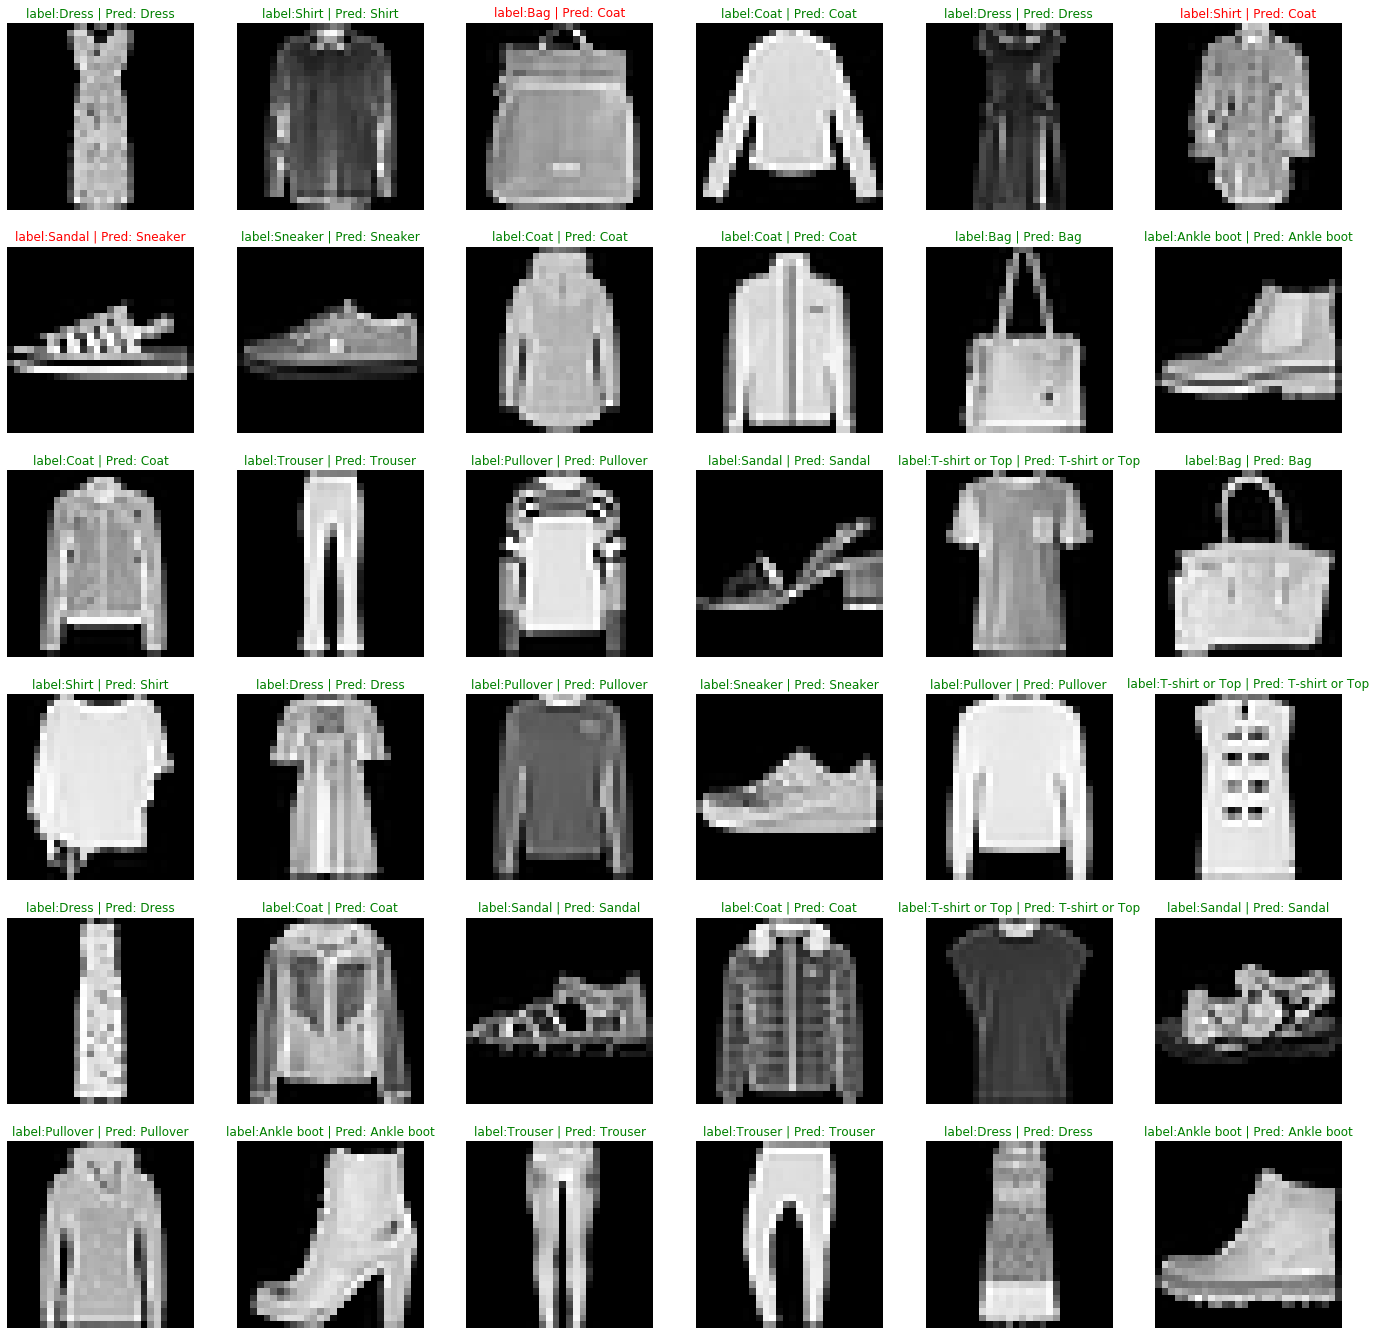

In [24]:
fig, axes = plt.subplots(6,6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28,28).cpu(), cmap='gray')
    font = {"color": 'r'} if label != pred else {"color": "g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"label:{label} | Pred: {pred}", fontdict=font);
    ax.axis('off');